# Example 3: Shorting and leveraged portfolios

This example follows from previous ones. If something in the preamble is confusing, it is explained there.

This example focuses on using the shorting constraints available to `Trad` and `WC` optimisations of `Portfolio`.

## 1. Downloading the data

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "YFinance", "Clarabel", "HiGHS", "CovarianceEstimation", "SparseArrays"])
using Clarabel, CovarianceEstimation, DataFrames, Dates, GraphRecipes, HiGHS, YFinance,
      PortfolioOptimiser, Statistics, StatsBase, StatsPlots, TimeSeries, LinearAlgebra,
      PrettyTables

fmt1 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return if isa(v, Number)
            "$(round(v*100, digits=3)) %"
        else
            v
        end
    end
end;

function stock_price_to_time_array(x)
    coln = collect(keys(x))[3:end] # only get the keys that are not ticker or datetime
    m = hcat([x[k] for k ∈ coln]...) #Convert the dictionary into a matrix
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end
assets = ["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC", "LULU",
          "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT", "SAVE", "SBUX",
          "SIRI", "STX", "TLRY", "TSLA"]
Date_0 = "2019-01-01"
Date_1 = "2023-01-01"
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets));

## 2. Instantiating an instance of `Portfolio`.

In [2]:
portfolio = Portfolio(; prices = prices,
                      # Continuous optimiser.
                      solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                       :check_sol => (allow_local = true,
                                                                      allow_almost = true),
                                                       :params => Dict("verbose" => false,
                                                                       "max_step_fraction" => 0.7))),
                      # MIP optimiser for the discrete allocation.
                      alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                          :check_sol => (allow_local = true,
                                                                         allow_almost = true),
                                                          :params => Dict("log_to_console" => false))));

In [3]:
mu_type = MuSimple()
cov_type = PortCovCor()
asset_statistics!(portfolio; mu_type = mu_type, cov_type = cov_type)

In [4]:
# Risk free rate.
rf = 3.5 / 100 / 252
# Risk aversion.
l = 2.0
# Objective function.
obj = MinRisk()
# Risk measure.
rm = SD()
# Money available to us.
investment = 6750;

## 3.1 Long-only portfolio

First we will optimise the portfolio without shorting and plot the weights and the efficient frontier.

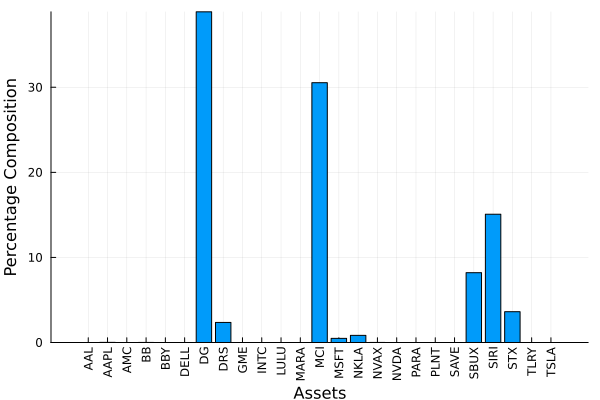

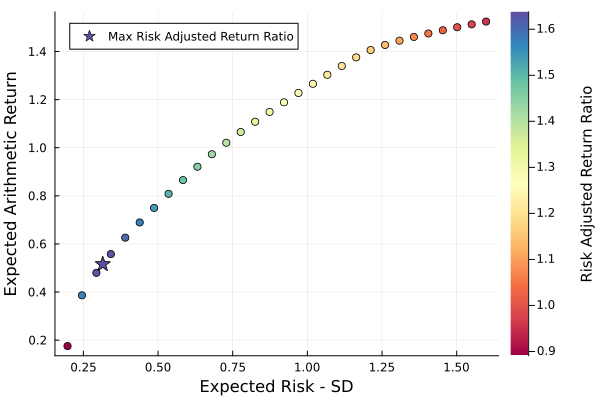

In [5]:
portfolio.short = false
portfolio.optimal[:ns] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :ns))
portfolio.frontier[:ns] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :ns))

We'll now allocate the portfolio according to our means. We'll use both allocation methods:

- Linear Mixed-integer Programming (LP): (default) can only allocate discrete integer shares and requires an MIP solver.
- Greedy algorithm, can round down to the nearest `integer + N*rounding`, but is not guaranteed to be globally optimal. The rounding also rounds down, as it ensures the investment will not be exceeded.

In [6]:
portfolio.optimal[:nsal] = allocate!(portfolio, :ns; method = LP(), investment = investment)
portfolio.optimal[:nsag] = allocate!(portfolio, :ns; method = Greedy(; rounding = 0.3),
                                     investment = investment);

Lets verify that the allocations used the money we have available. We'll also compare the would-be optimal portfolio.

Optimal portfolio

In [7]:
long_optimal_idx = portfolio.optimal[:ns].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment = $(sum(investment * portfolio.optimal[:ns].weights[long_optimal_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:ns].weights[long_optimal_idx]))")

Optimal investment = 6750.0
Sum of weights = 1.0


LP allocated portfolio

In [8]:
long_LP_idx = portfolio.optimal[:nsal].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:nsal].shares[long_LP_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:nsal].weights[long_LP_idx]))")

Allocation investment = 6749.179164886475
Sum of weights = 0.9998783947979963


Greedy allocated portfolio

In [9]:
long_Greedy_idx = portfolio.optimal[:nsag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:nsag].shares[long_Greedy_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:nsag].weights[long_Greedy_idx]))")

Allocation investment = 6434.093272399902
Sum of weights = 0.9531990033185042


As you can see, the greedy algorithm doesn't make optimal use of the available investment.

Lets now see what the long-only portfolio looks like, in both optimal and allocated form.

In [10]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights without shorting.
                       ns_w = portfolio.optimal[:ns].weights,
                       # Discretely allocated optimal weights without shorting.
                       # Linear programming.
                       nsal_w = portfolio.optimal[:nsal].weights,
                       # Discretely allocated shares without shorting.
                       # Linear programming.
                       nsal_s = portfolio.optimal[:nsal].shares,
                       # Discretely allocated optimal weights without shorting.
                       # Greedy algorithm.
                       nsag_w = portfolio.optimal[:nsag].weights,
                       # Discretely allocated shares without shorting.
                       # Greedy algorithm.
                       nsag_s = portfolio.optimal[:nsag].shares))

┌─────────┬─────────────┬───────────┬────────┬───────────┬─────────┐
│ tickers │        ns_w │    nsal_w │ nsal_s │    nsag_w │  nsag_s │
│  String │     Float64 │   Float64 │  Int64 │   Float64 │ Float64 │
├─────────┼─────────────┼───────────┼────────┼───────────┼─────────┤
│     AAL │  4.98718e-7 │       0.0 │      0 │       0.0 │     0.0 │
│    AAPL │ 0.000135161 │       0.0 │      0 │       0.0 │     0.0 │
│     AMC │  7.26304e-7 │       0.0 │      0 │       0.0 │     0.0 │
│      BB │  3.19159e-5 │       0.0 │      0 │       0.0 │     0.0 │
│     BBY │  1.06993e-6 │       0.0 │      0 │       0.0 │     0.0 │
│    DELL │  6.16928e-6 │       0.0 │      0 │       0.0 │     0.0 │
│      DG │    0.388695 │  0.391608 │     11 │  0.366688 │    10.3 │
│     DRS │   0.0235916 │   0.02272 │     12 │   0.02272 │    12.0 │
│     GME │  5.63541e-7 │       0.0 │      0 │       0.0 │     0.0 │
│    INTC │  4.50796e-6 │       0.0 │      0 │       0.0 │     0.0 │
│    LULU │  1.03742e-6 │       0.

## 3.2 Shorting

Enabling shorting is very simple. This will allow negative weights, which correspond to shorting portfolios. It is generally a good idea to start with little to no leverage.

In [11]:
portfolio.short = true;

How short- or long-heavy we want to be is mediated by the `short_u` and `long_u` properties. They set the upper bound for the absolute value of the sum of the short and long weights respectively.

- `short_u`: the absolute value of the sum of the short weights will be less than this.
- `long_u`: the sum of the long weights will be less than this.

These values multiply the cash at our disposal when we allocate the portfolio. So when `allocate!` is called, the long investment will be `investment * long_u`. And if shorting is enabled, the short investment (the amount shorted) will be `short_u * investment`.

Lets short the market whithout reinvesting the earnings, meaning we'll have a cash reserve in our balance that is equal to the short sale value. You can change this by increasing `long_u`, if you set it to `1 + short_u` it means the profits from short selling will be reinvested into the portfolio.

We will use the default values.

In [12]:
# The absolute value of the sum of the short weights is equal to `0.2`.
portfolio.short_u = 0.2
# Long weights add up to `1.0`.
portfolio.long_u = 1;

The portfolio `budget = long_u - short_u` gives us the leverage characteristics of the portfolio. This is a property that is automatically computed and cannot be cahnged. There are verious scenarios that `budget` describes.

- `budget < 0`: the short sale value of the portfolio is higher than the long-sale value.
- `budget == 0`: the short and long values of the portfolio are equal. The market neutral portfolio is found by maximising the return given these conditions.
- `0 < budget < 1`: the portfolio is under-leveraged, meaning there is a cash reserve that is not being used.
- ` budget == 1`: the portfolio has no leverage. If shorting is enabled, this means the profits from shorting are being invested in long positions.
- `budget < 1`: the portfolio is leveraged, meaning it's using more money than is available.

Here the portfolio is under-leveraged.

In [13]:
portfolio.budget == 0.8

true

Lets optimise the short-long portfolio.

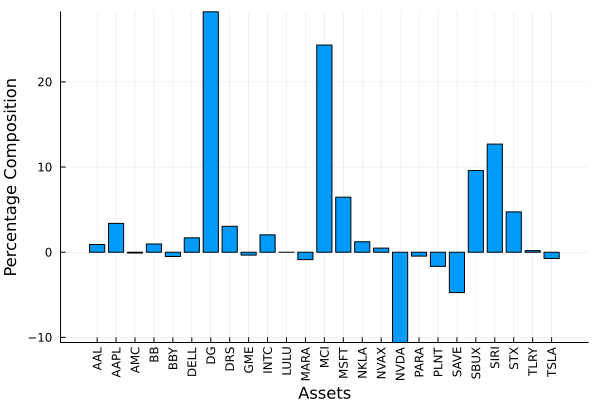

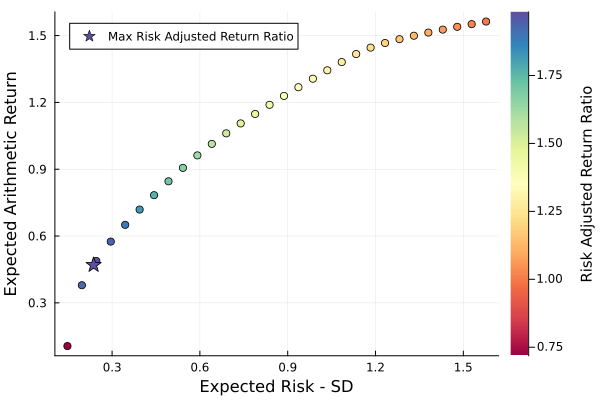

In [14]:
portfolio.optimal[:s] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :s))
portfolio.frontier[:s] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :s))

Lets allocate the short-long portfolio.

In [15]:
# Allocating the short-long portfolio.
portfolio.optimal[:sal] = allocate!(portfolio, :s; investment = investment)
portfolio.optimal[:sag] = allocate!(portfolio, :s; method = Greedy(; rounding = 0.3),
                                    investment = investment);

Lets verify that the allocations used the money we have available.

Optimal portfolio

In [16]:
long_optimal_idx = portfolio.optimal[:s].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment")
println("long = $(sum(investment * portfolio.optimal[:s].weights[long_optimal_idx]))")
println("short = $(sum(investment * portfolio.optimal[:s].weights[short_optimal_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:s].weights[long_optimal_idx]))")
println("short = $(sum(portfolio.optimal[:s].weights[short_optimal_idx]))")

Optimal investment
long = 6749.929991968354
short = -1349.9299919683529
Sum of weights
long = 0.9999896284397561
short = -0.19998962843975596


LP allocated portfolio

In [17]:
long_LP_idx = portfolio.optimal[:sal].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:sal].shares[long_LP_idx]))")
println("short = $(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sal].shares[short_LP_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sal].weights[long_LP_idx]))")
println("short = $(sum(portfolio.optimal[:sal].weights[short_LP_idx]))")

Allocation investment
long = 6749.96088552475
short = -1347.700837135315
Sum of weights
long = 0.9999942052629259
short = -0.1996593832793059


Greedy allocated portfolio

In [18]:
long_Greedy_idx = portfolio.optimal[:sag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:sag].shares[long_Greedy_idx]))")
println("short = $(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:sag].shares[short_Greedy_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sag].weights[long_Greedy_idx]))")
println("short = $(sum(portfolio.optimal[:sag].weights[short_Greedy_idx]))")

Allocation investment
long = 6238.554977464676
short = -1236.9049587249756
Sum of weights
long = 0.9242303670318037
short = -0.18324517907036675


Here's what the short-long portfolio looks like. See how this differs from the long-only portfolio.

In [19]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights with shorting.
                       s_w = portfolio.optimal[:s].weights,
                       # Discretely allocated optimal weights with shorting.
                       # Linear programming.
                       sal_w = portfolio.optimal[:sal].weights,
                       # Discretely allocated shares with shorting.
                       # Linear programming.
                       sal_s = portfolio.optimal[:sal].shares,
                       # Discretely allocated optimal weights with shorting.
                       # Greedy algorithm.
                       sag_w = portfolio.optimal[:sag].weights,
                       # Discretely allocated shares with shorting.
                       # Greedy algorithm.
                       sag_s = portfolio.optimal[:sag].shares))

┌─────────┬──────────────┬─────────────┬───────┬─────────────┬─────────┐
│ tickers │          s_w │       sal_w │ sal_s │       sag_w │   sag_s │
│  String │      Float64 │     Float64 │ Int64 │     Float64 │ Float64 │
├─────────┼──────────────┼─────────────┼───────┼─────────────┼─────────┤
│     AAL │   0.00904725 │  0.00753778 │     4 │  0.00866844 │     4.6 │
│    AAPL │     0.033906 │   0.0381391 │     2 │   0.0247904 │     1.3 │
│     AMC │ -0.000942123 │        -0.0 │     0 │        -0.0 │    -0.0 │
│      BB │   0.00971803 │  0.00965926 │    20 │  0.00965926 │    20.0 │
│     BBY │  -0.00499263 │        -0.0 │     0 │        -0.0 │    -0.0 │
│    DELL │    0.0169213 │   0.0171565 │     3 │    0.014869 │     2.6 │
│      DG │      0.28231 │    0.284806 │     8 │    0.249205 │     7.0 │
│     DRS │    0.0304739 │   0.0302933 │    16 │      0.0284 │    15.0 │
│     GME │  -0.00335237 │ -0.00273481 │    -1 │ -0.00273481 │    -1.0 │
│    INTC │    0.0203884 │   0.0188784 │     5 │   

## 3.3 Shorting with reinvestment

In this section we'll reinvest the money made from short selling, this can be acomplished by setting the value of `long_u = 1 + short_u`.

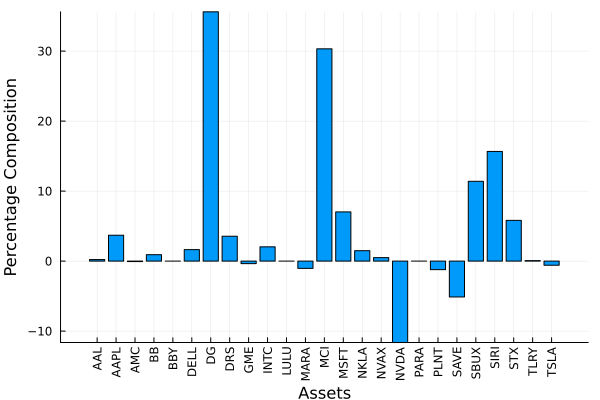

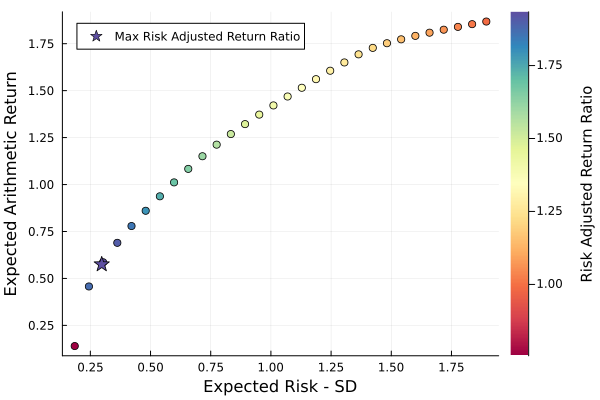

In [20]:
portfolio.short = true

# The absolute value of the sum of the short weights is equal to `0.2`.
portfolio.short_u = 0.2
# Long weights add up to `1.2`, which means reinvesting the gains from shorting.
portfolio.long_u = 1 + portfolio.short_u
# No leverage.
portfolio.budget == 1

portfolio.optimal[:sr] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :sr))
portfolio.frontier[:sr] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :sr))

Lets allocate the short-long portfolio.

In [21]:
# Allocating the short-long portfolio.
portfolio.optimal[:sral] = allocate!(portfolio, :sr; investment = investment)
portfolio.optimal[:srag] = allocate!(portfolio, :sr; method = Greedy(; rounding = 0.3),
                                     investment = investment);

Lets verify that the allocations used the money we have available.

Optimal portfolio

In [22]:
long_optimal_idx = portfolio.optimal[:sr].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment")
println("long = $(sum(investment * portfolio.optimal[:sr].weights[long_optimal_idx]))")
println("long = $(investment + abs(sum(investment * portfolio.optimal[:sr].weights[short_optimal_idx]))) = investment + short_profit")
println("short = $(sum(investment * portfolio.optimal[:sr].weights[short_optimal_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sr].weights[long_optimal_idx]))")
println("short = $(sum(portfolio.optimal[:sr].weights[short_optimal_idx]))")

Optimal investment
long = 8099.973509266946
long = 8099.973509266944 = investment + short_profit
short = -1349.9735092669441
Sum of weights
long = 1.1999960754469547
short = -0.19999607544695466


LP allocated portfolio

In [23]:
long_LP_idx = portfolio.optimal[:sral].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:sral].shares[long_LP_idx]))")
println("long ≈ $(investment + abs(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sral].shares[short_LP_idx]))) ≈ investment + short_profit")
println("short = $(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sral].shares[short_LP_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sral].weights[long_LP_idx]))")
println("short = $(sum(portfolio.optimal[:sral].weights[short_LP_idx]))")

Allocation investment
long = 8098.730342626572
long ≈ 8095.164344787598 ≈ investment + short_profit
short = -1345.1643447875977
Sum of weights
long = 1.1998119026113439
short = -0.19928360663519964


Greedy allocated portfolio

In [24]:
long_Greedy_idx = portfolio.optimal[:srag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:srag].shares[long_Greedy_idx]))")
println("long ≈ $(investment + abs(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:srag].shares[short_Greedy_idx]))) ≈ investment + short_profit")
println("short = $(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:srag].shares[short_Greedy_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:srag].weights[long_Greedy_idx]))")
println("short = $(sum(portfolio.optimal[:srag].weights[short_Greedy_idx]))")

Allocation investment
long = 7489.747557353973
long ≈ 7987.278123283386 ≈ investment + short_profit
short = -1237.2781232833863
Sum of weights
long = 1.109592230719107
short = -0.18330046270864986


Here's what the short-long portfolio looks like when we reinvest profits from shorting.

In [25]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights with shorting.
                       s_w = portfolio.optimal[:sr].weights,
                       # Discretely allocated optimal weights with shorting.
                       # Linear programming.
                       sal_w = portfolio.optimal[:sral].weights,
                       # Discretely allocated shares with shorting.
                       # Linear programming.
                       sal_s = portfolio.optimal[:sral].shares,
                       # Discretely allocated optimal weights with shorting.
                       # Greedy algorithm.
                       sag_w = portfolio.optimal[:srag].weights,
                       # Discretely allocated shares with shorting.
                       # Greedy algorithm.
                       sag_s = portfolio.optimal[:srag].shares))

┌─────────┬──────────────┬─────────────┬───────┬─────────────┬─────────┐
│ tickers │          s_w │       sal_w │ sal_s │       sag_w │   sag_s │
│  String │      Float64 │     Float64 │ Int64 │     Float64 │ Float64 │
├─────────┼──────────────┼─────────────┼───────┼─────────────┼─────────┤
│     AAL │   0.00221496 │  0.00188444 │     1 │         0.0 │     0.0 │
│    AAPL │    0.0370177 │   0.0381391 │     2 │   0.0305113 │     1.6 │
│     AMC │ -0.000630156 │        -0.0 │     0 │ -0.00180889 │    -0.3 │
│      BB │    0.0091684 │   0.0091763 │    19 │  0.00869333 │    18.0 │
│     BBY │  -6.32916e-7 │        -0.0 │     0 │        -0.0 │    -0.0 │
│    DELL │    0.0164281 │   0.0171565 │     3 │   0.0131533 │     2.3 │
│      DG │     0.356141 │    0.356008 │    10 │    0.320407 │     9.0 │
│     DRS │    0.0355979 │     0.03408 │    18 │     0.03408 │    18.0 │
│     GME │  -0.00354453 │ -0.00546963 │    -2 │ -0.00355526 │    -1.3 │
│    INTC │     0.020449 │   0.0188784 │     5 │   

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*